In [2]:
# 1. Install the specific libraries required
!pip install -U flwr[simulation] flwr-datasets[vision] torch torchvision matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.4/71.4 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.7/899.7 MB 822.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 122.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 75.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 80.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.5/267.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3

In [17]:
# 1. Import Libraries
# ===============================
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, ToTensor, Normalize
from flwr_datasets import FederatedDataset
import flwr as fl
from typing import List, Tuple, Dict
import matplotlib.pyplot as plt
import numpy as np
import random


In [18]:
# ===============================
# 2. Reproducibility
# ===============================
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)


In [19]:
# 3. Device
# ===============================
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


In [20]:
# ===============================
# 4. Define CNN Model
# ===============================
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [21]:
# ===============================
# 5. Training & Testing Functions
# ===============================
def train(net, trainloader, epochs=1):
    net.train()
    optimizer = torch.optim.Adam(net.parameters())
    for _ in range(epochs):
        for batch in trainloader:
            images, labels = batch["image"].to(DEVICE), batch["label"].to(DEVICE)
            optimizer.zero_grad()
            loss = F.cross_entropy(net(images), labels)
            loss.backward()
            optimizer.step()
def test(net, testloader):
    net.eval()
    criterion = nn.CrossEntropyLoss()
    total_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in testloader:
            images, labels = batch["image"].to(DEVICE), batch["label"].to(DEVICE)
            outputs = net(images)
            total_loss += criterion(outputs, labels).item() * labels.size(0)
            correct += (outputs.argmax(dim=1) == labels).sum().item()
            total += labels.size(0)
    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy




In [22]:
# ===============================
# 6. Load Federated MNIST Data
# ===============================
NUM_CLIENTS = 10
fds = FederatedDataset(dataset="mnist", partitioners={"train": NUM_CLIENTS})

def load_data(partition_id):
    partition = fds.load_partition(partition_id, "train")
    partition_train_test = partition.train_test_split(test_size=0.2, seed=SEED)

    pytorch_transforms = Compose([ToTensor(), Normalize((0.1307,), (0.3081,))])

    def apply_transforms(batch):
        batch["image"] = [pytorch_transforms(img) for img in batch["image"]]
        return batch

    trainset = partition_train_test["train"].with_transform(apply_transforms)
    testset = partition_train_test["test"].with_transform(apply_transforms)

    return DataLoader(trainset, batch_size=32, shuffle=True), DataLoader(testset, batch_size=32)


In [23]:
# ===============================
# 7. Flower Client
# ===============================
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, net, trainloader, testloader):
        self.net = net
        self.trainloader = trainloader
        self.testloader = testloader

    def get_parameters(self, config):
        return [val.cpu().numpy() for _, val in self.net.state_dict().items()]

    def set_parameters(self, parameters):
        params_dict = zip(self.net.state_dict().keys(), parameters)
        state_dict = {k: torch.tensor(v) for k, v in params_dict}
        self.net.load_state_dict(state_dict, strict=True)

    def fit(self, parameters, config):
        self.set_parameters(parameters)
        train(self.net, self.trainloader, epochs=1)
        return self.get_parameters(config={}), len(self.trainloader.dataset), {}

    def evaluate(self, parameters, config):
        self.set_parameters(parameters)
        loss, accuracy = test(self.net, self.testloader)
        return float(loss), len(self.testloader.dataset), {"accuracy": float(accuracy)}

def client_fn(cid: str):
    net = Net().to(DEVICE)
    trainloader, testloader = load_data(int(cid))
    return FlowerClient(net, trainloader, testloader)



In [24]:
# ===============================
# 8. Server Strategy
# ===============================
def weighted_average(metrics: List[Tuple[int, Dict]]) -> Dict:
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]
    return {"accuracy": sum(accuracies) / sum(examples)}

strategy = fl.server.strategy.FedAvg(
    fraction_fit=1.0,
    fraction_evaluate=0.5,
    min_fit_clients=5,
    min_evaluate_clients=5,
    min_available_clients=NUM_CLIENTS,
    evaluate_metrics_aggregation_fn=weighted_average,
)

In [25]:
# 7. Start Simulation
history = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=5),
    strategy=strategy,
    client_resources={"num_cpus": 1, "num_gpus": 0.1 if torch.cuda.is_available() else 0},
)


	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
INFO :      Starting Flower simulation, config: num_rounds=5, no round_timeout
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
2026-01-19 13:37:59,939	INFO worker.py:2012 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'GPU': 1.0, 'node:172.28.0.12': 1.0, 'memory': 9149714023.0, 'CPU': 2.0

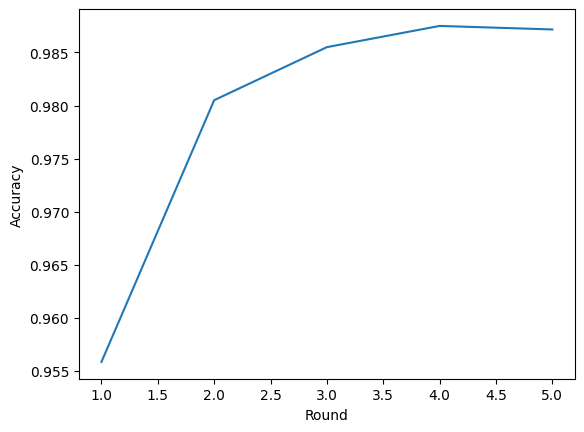

In [26]:
# 8. Plot results
rounds, acc = zip(*history.metrics_distributed["accuracy"])
plt.plot(rounds, acc)
plt.xlabel("Round")
plt.ylabel("Accuracy")
plt.show()